In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
start_val = 3

In [10]:
df = pd.read_csv('../csv/time_benchmark/rep100_p3_bias1_cifarinc.csv')

configs = [
    ('TensorSketch', df[(df['proj'] == 'countsketch_scatter')]),
#     ('Rademacher real', df[(df['proj'] == 'rademacher') & (df['full_cov'] == False) & (df['complex_real'] == False)]),
#     ('Rademacher comp..', df[(df['proj'] == 'rademacher') & (df['full_cov'] == False) & (df['complex_real'] == True)])
    ('TensorSRHT real', df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]),
    ('TensorSRHT comp.', df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == True)])
]

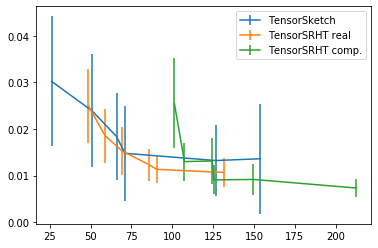

In [11]:
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
for config in configs:
    plt.errorbar(config[1]['metric_time_ms'].values[start_val:], config[1]['frob_mean'].values[start_val:], yerr=config[1]['frob_std'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

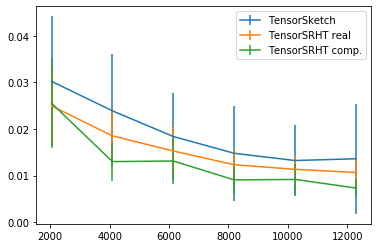

In [12]:
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
for config in configs:
    plt.errorbar(config[1]['D'].values[start_val:], config[1]['frob_mean'].values[start_val:], yerr=config[1]['frob_std'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

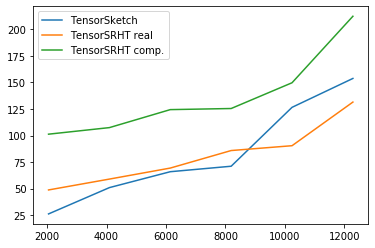

In [13]:
# full cov
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
for config in configs:
    plt.plot(config[1]['D'].values[start_val:], config[1]['metric_time_ms'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

# MNIST Conv

In [4]:
df = pd.read_csv('../csv/time_benchmark/rep100_p3_bias1_mnist.csv')

configs = [
    ('TensorSketch', df[(df['proj'] == 'countsketch_scatter')]),
#     ('Rademacher real', df[(df['proj'] == 'rademacher') & (df['full_cov'] == False) & (df['complex_real'] == False)]),
#     ('Rademacher comp..', df[(df['proj'] == 'rademacher') & (df['full_cov'] == False) & (df['complex_real'] == True)]),
    ('TensorSRHT real', df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]),
    ('TensorSRHT comp.', df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == True)])
]

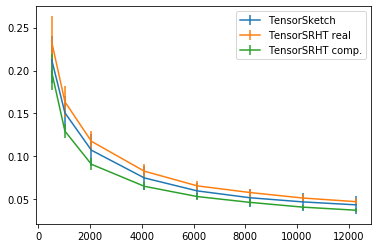

In [26]:
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
for config in configs:
    plt.errorbar(config[1]['D'].values[start_val:], config[1]['frob_mean'].values[start_val:], yerr=config[1]['frob_std'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

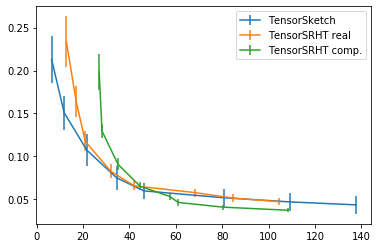

In [28]:
# full cov
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
for config in configs:
    plt.errorbar(config[1]['metric_time_ms'].values[start_val:], config[1]['frob_mean'].values[start_val:], yerr=config[1]['frob_std'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

D: [  512.  1024.  2048.  4096.  6144.  8192. 10240. 12288.]


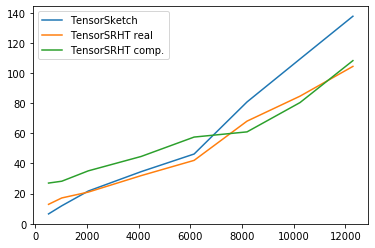

In [5]:
# full cov, MNIST conv
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
print('D:', configs[0][1]['D'].values[start_val:])
for config in configs:
    plt.plot(config[1]['D'].values[start_val:], config[1]['metric_time_ms'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

## Adult

In [6]:
df = pd.read_csv('../csv/time_benchmark/rep100_p3_bias1_adult.csv')

configs = [
    ('TensorSketch', df[(df['proj'] == 'countsketch_scatter')]),
#     ('Rademacher real', df[(df['proj'] == 'rademacher') & (df['full_cov'] == False) & (df['complex_real'] == False)]),
#     ('Rademacher comp..', df[(df['proj'] == 'rademacher') & (df['full_cov'] == False) & (df['complex_real'] == True)]),
    ('TensorSRHT real', df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]),
    ('TensorSRHT comp.', df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == True)])
]

D: [ 128.  256.  384.  512.  640.  768.  896. 1024. 1152. 1280.]


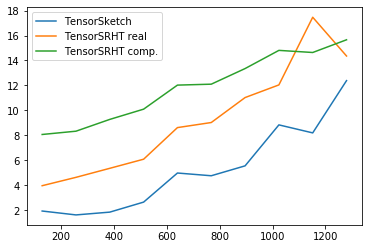

In [9]:
# full cov
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
print('D:', configs[0][1]['D'].values[:])
for config in configs:
    plt.plot(config[1]['D'].values[:], config[1]['metric_time_ms'].values[:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()

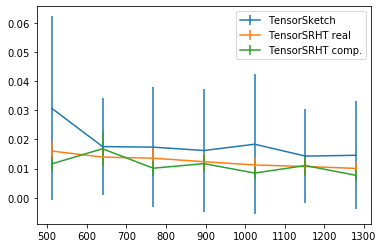

In [10]:
# tensorsrht_real = df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]
for config in configs:
    plt.errorbar(config[1]['D'].values[start_val:], config[1]['frob_mean'].values[start_val:], yerr=config[1]['frob_std'].values[start_val:], label=config[0])
# plt.errorbar(tensorsketch['metric_time_ms'].values, tensorsketch['frob_mean'].values, yerr=tensorsketch['frob_std'].values)
plt.legend()
plt.show()